In [1]:
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from Utils.rl_glue import RLGlue
from tqdm import tqdm
import pickle
import gym
import sys
from Utils import envVisual
from Agents import agent
from Agents.QLearningAgent import QLearningAgent
from Agents.ExpectedSarsaAgent import ExpectedSarsaAgent
from Environments import environment
from copy import deepcopy
from gym.spaces import Discrete, MultiDiscrete
import random

In [27]:
class MultiAgentEnvironment(environment.BaseEnvironment):
    """Implements the environment for an RLGlue environment
    Note:
        env_init, env_start, env_step, env_cleanup, and env_message are required
        methods.
    """

    # def __init__(self):
    def env_init(self, env_info={}):
        """Setup for the environment called when the experiment first starts.

        Note:
            Initialize a tuple with the reward, first state observation, boolean
            indicating if it's terminal.
        """
        self.rows = 5
        self.cols = 5

        self.winner = None

        self.observation_space = MultiDiscrete([self.rows * self.cols, self.rows * self.cols])
        self.action_space = Discrete(4)

        self.agent1_pos = [0, 4]
        self.agent2_pos = [4, 0]

        self.agent1_R = 0.0
        self.agent2_R = 0.0

        self.agent1_visited_fields = set([tuple(self.agent1_pos)])
        self.agent1_goal = [4, 0]

        self.collision = False
        self.num_collisions = 0

        self.current_state = None
        
        return self.current_state

    def env_start(self):
        """The first method called when the episode starts, called before the
        agent starts.

        Returns:
            The first state observation from the environment.
        """
        self.current_state = [self.agent1_pos, self.agent2_pos]
        return self.observation(self.current_state)

       
    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (float, state, Boolean): a tuple of the reward, state observation,
                and boolean indicating if it's terminal.
        """
        is_terminal = False
        # Agent2 always moves first
        events = self._move(self.agent2_pos, action["agent2"], is_agent1=False)
        events |= self._move(self.agent1_pos, action["agent1"], is_agent1=True)

        # self.current_state = [self.agent1_pos, self.agent2_pos]
        observations = self.observation(self.current_state)
        # Determine rewards based on the collected events:
        # reward of agent 1 = 1 if agent 1 move into a new cell, -1 if agent 1 got collision with agent 2, else -0.5
        # reward of agent 2 = 1 if agent 2 got collision with agent 1, else -0.1

        # Escape is prior to collision
        if "escape" in events:
            r1 = 100.0
            r2 = -100.0
            is_terminal = True
            self.winner = "thief"
        elif "collision" in events:
            r1 = -100.0
            r2 = 100.0
            is_terminal = True
            self.winner = "police"
        else:
            r1 = 1.0 if "agent1_new_field" in events else -0.5
            r2 = -1.0

        self.agent1_R += r1
        self.agent2_R += r2

        rewards = {
            "agent1": r1,
            "agent2": r2,
        }

        # Generate a `done` dict (per-agent and total).
        dones = {
            "agent1": is_terminal,
            "agent2": is_terminal,
            # special `__all__` key indicates that the episode is done for all agents.
            "__all__": is_terminal,
        }

        self.reward_obs_term = (rewards, observations, dones)

        return self.reward_obs_term

    def observation(self, state):
        agent1 = state[0][0] * self.cols + state[0][1]
        agent2 = state[1][0] * self.cols + state[1][1]

        return [agent1, agent2]

    def _move(self, coords, action, is_agent1):
        """
        Moves an agent (agent1 if is_agent1=True, else agent2) from `coords` (x/y) using the
        given action (0=up, 1=right, etc..) and returns a resulting events dict:
        Agent1: "new" when entering a new field. "bumped" when having been bumped into by agent2.
        Agent2: "bumped" when bumping into agent1 (agent1 then gets -1.0).
        """

        orig_coords = coords[:]
        if action == 0: #right
            coords[1] = min(coords[1]+1, self.cols-1)
        elif action == 1: #down
            coords[0] = max(coords[0]-1, 0)
        elif action == 2: #left
            coords[1] = max(coords[1]-1, 0)
        elif action == 3: #up
            coords[0] = min(coords[0]+1, self.rows-1)
        else:
            raise Exception("Invalid action.")
        
        # if agent1 reaches the target position, ignore collisions
        if (is_agent1 and coords == self.agent1_goal):
            return {"escape"}
        
        # Solve collisions
        # If yes, get blocked
        if (is_agent1 and coords == self.agent2_pos) or (not is_agent1 and coords == self.agent1_pos):
            coords[0], coords[1] = orig_coords
            # Agent2 blocked agent1 (agent1 tried to run into agent2)
            # OR Agent2 bumped into agent1 (agent2 tried to run into agent1)
            return {"collision"}
        
        # If agent1 -> "new" if new tile covered.
        if is_agent1 and not tuple(coords) in self.agent1_visited_fields:
            self.agent1_visited_fields.add(tuple(coords))
            return {"agent1_new_field"}
        # No new tile for agent1.
        return set()


    def env_cleanup(self):
        """Cleanup done after the environment ends"""
        pass

    def env_message(self, message):
        """A message asking the environment for information

        Args:
            message (string): the message passed to the environment

        Returns:
            string: the response (or answer) to the message
        """
        if message == "what is the current reward?":
            return "{}".format(self.reward_obs_term[0])

        # else
        return "I don't know how to respond to your message"
    
    def render(self):
        """Render the current state of the environment using Matplotlib"""
        grid = np.zeros((self.rows, self.cols))

        # Mark start, goal, and current positions
        start_row, start_col = self.start
        goal_row, goal_col = self.goal
        current_row, current_col = self.current_state
        grid[start_row, start_col] = 0.5  # Start position
        grid[goal_row, goal_col] = 1.0    # Goal position
        grid[current_row, current_col] = 0.8  # Current position

        # Create the plot
        plt.imshow(grid, cmap='gray', origin='upper', interpolation='none')

        # Add grid lines
        plt.grid(which='both', color='gray', linestyle='-', linewidth=1)

        plt.xticks(np.arange(-0.5, self.cols, 1))
        plt.yticks(np.arange(-0.5, self.rows, 1))

        plt.title('Grid Environment')
        plt.xlabel('Column')
        plt.ylabel('Row')

        plt.colorbar(label='State Value')

        plt.show()

In [16]:
def plot_grid(agent1_pos, agent2_pos, episode_num):
    # Create a grid
    grid = np.zeros((MA_env.rows, MA_env.cols))

    # Mark agent 1 and agent 2 positions on the grid
    grid[agent1_pos[0], agent1_pos[1]] = 1  # Agent 1 position
    grid[agent2_pos[0], agent2_pos[1]] = 2  # Agent 2 position

    # Plot the grid
    plt.imshow(grid, cmap='viridis', origin='upper', interpolation='none')
    plt.title('Episode {}'.format(episode_num))
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.colorbar(label='Agent')

    plt.xticks(np.arange(-0.5, MA_env.cols, 1))
    plt.yticks(np.arange(-0.5, MA_env.rows, 1))

    plt.grid(color='gray', linestyle='-', linewidth=1)
    plt.show()

In [ ]:
# Test the environment with random policy
MA_env = MultiAgentEnvironment()
total_rewards = []

for episode in range(1):
    MA_env.env_init()
    print("Episode:", episode + 1)
    total_reward = 0
    
    # Reset the environment
    obs = MA_env.env_start()
    print("Initial State:", obs)

    done = False

    # Continue until the episode terminates
    while not done:
        # Choose random actions for both agents
        action1 = np.random.randint(MA_env.action_space.n)
        action2 = np.random.randint(MA_env.action_space.n)
        print("Agent 1 Action:", action1)
        print("Agent 2 Action:", action2)

        # Take a step in the environment
        rewards, obs, dones = MA_env.env_step({"agent1": action1, "agent2": action2})
        total_reward += rewards["agent1"]
        total_reward += rewards["agent2"]

        print("Rewards:", rewards)
        print("New State:", obs)

        # Plot the grid
        plot_grid(MA_env.agent1_pos, MA_env.agent2_pos, episode + 1)

        # Check if the episode is done
        done = dones["__all__"]
        print("Episode Done:", done)

    total_rewards.append(total_reward)
    print("Total Reward for Episode {}: {}".format(episode + 1, total_reward))
    print("Reward for the thief: {}".format(MA_env.agent1_R))
    print("Reward for the policy: {}".format(MA_env.agent2_R))

Episode: 1
Rewards: {'agent1': -0.5, 'agent2': -1.0}
New State: [4, 15]


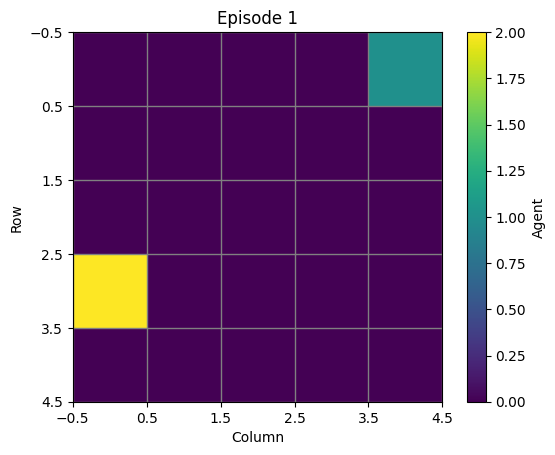

Rewards: {'agent1': 1.0, 'agent2': -1.0}
New State: [9, 20]


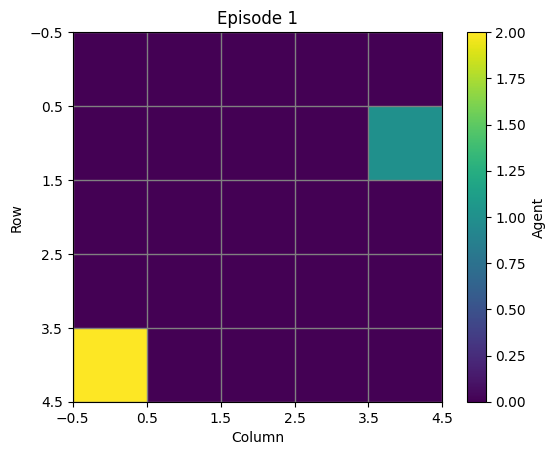

Rewards: {'agent1': 1.0, 'agent2': -1.0}
New State: [14, 20]


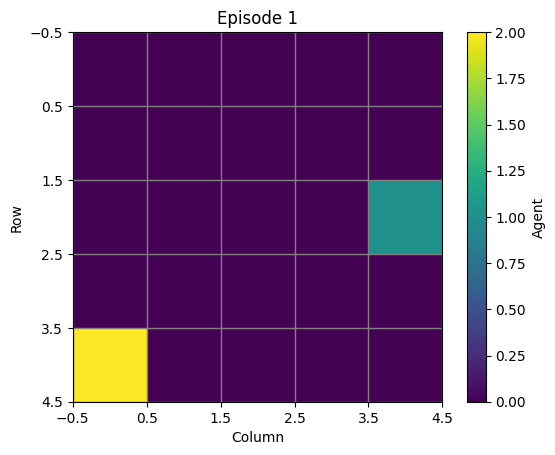

Rewards: {'agent1': 1.0, 'agent2': -1.0}
New State: [19, 20]


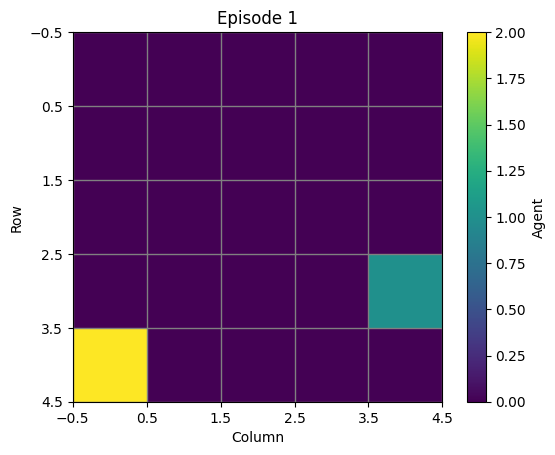

Rewards: {'agent1': -0.5, 'agent2': -1.0}
New State: [19, 21]


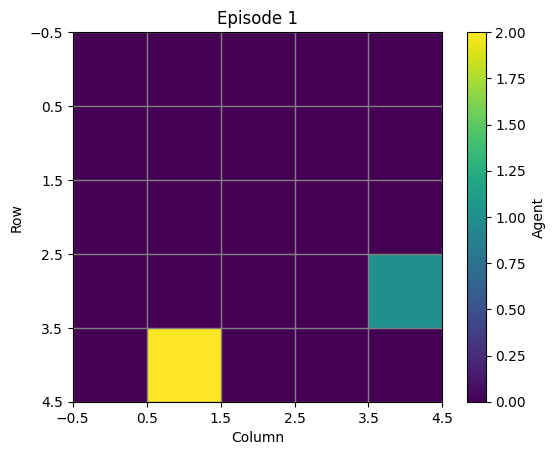

Rewards: {'agent1': 1.0, 'agent2': -1.0}
New State: [24, 22]


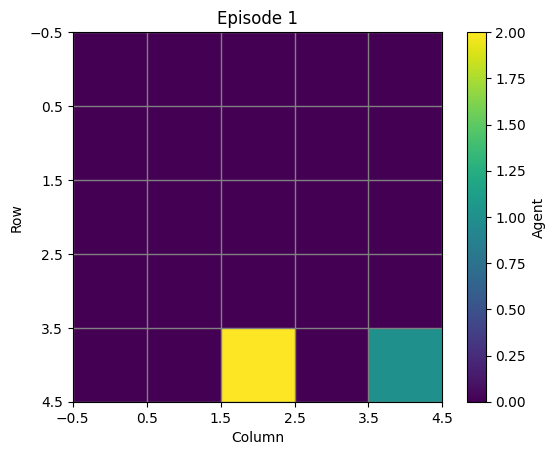

Rewards: {'agent1': -0.5, 'agent2': -1.0}
New State: [19, 21]


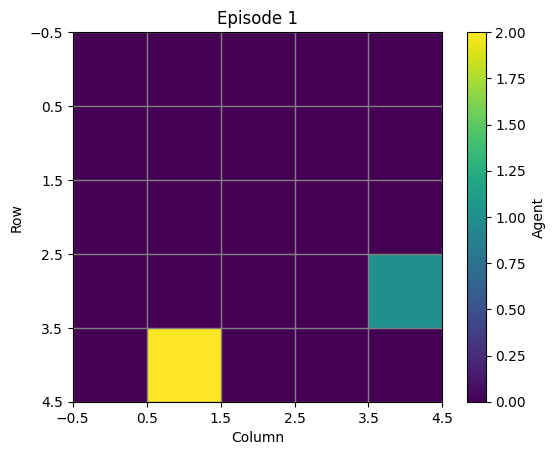

Rewards: {'agent1': -0.5, 'agent2': -1.0}
New State: [24, 21]


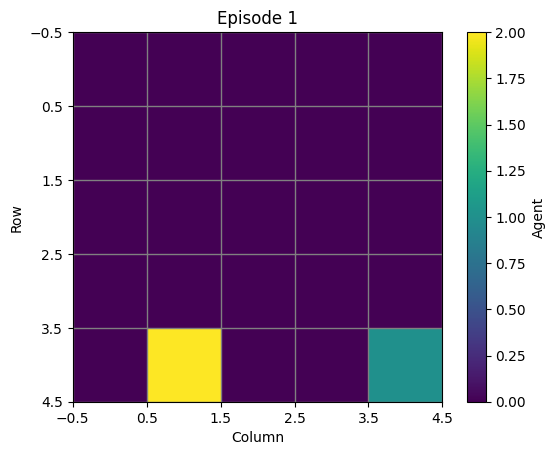

Rewards: {'agent1': -0.5, 'agent2': -1.0}
New State: [24, 20]


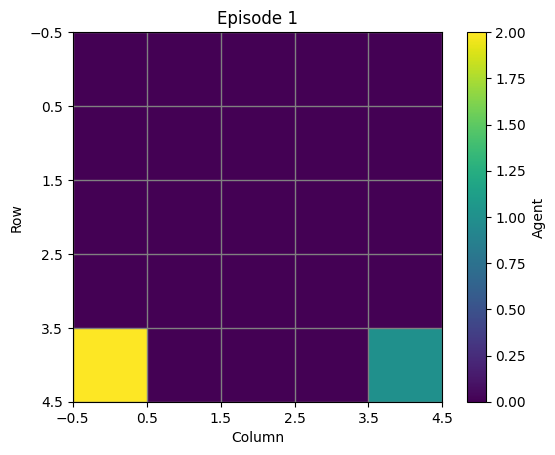

Rewards: {'agent1': -0.5, 'agent2': -1.0}
New State: [24, 21]


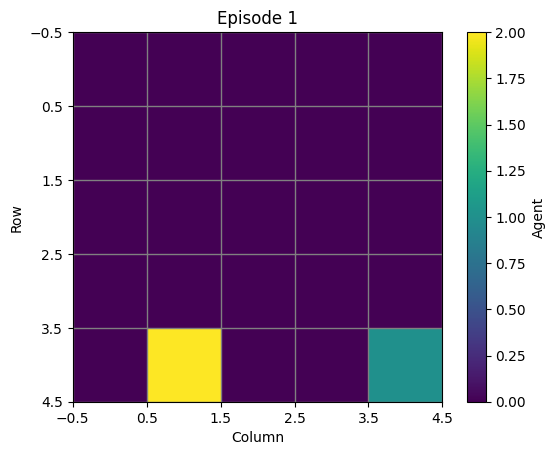

Rewards: {'agent1': 1.0, 'agent2': -1.0}
New State: [23, 21]


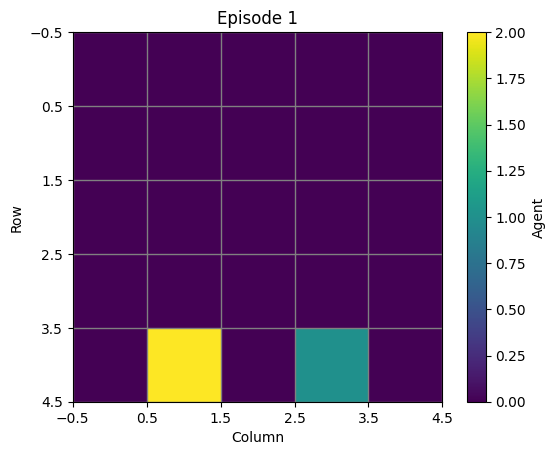

Rewards: {'agent1': -0.5, 'agent2': -1.0}
New State: [23, 16]


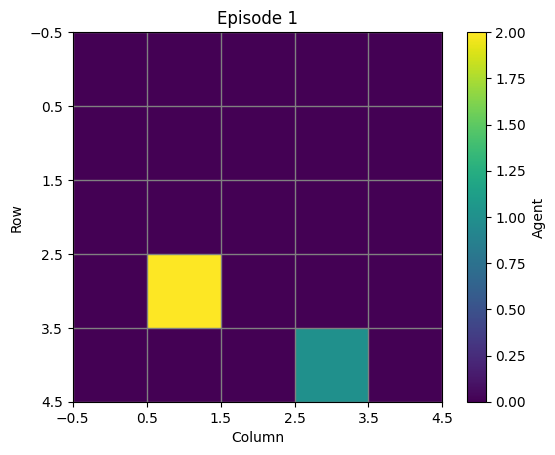

Rewards: {'agent1': -0.5, 'agent2': -1.0}
New State: [24, 21]


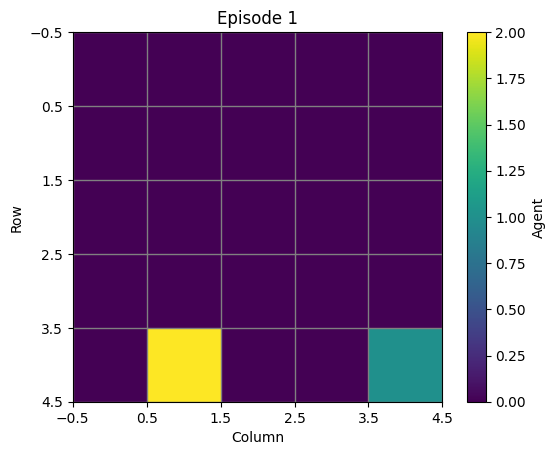

Rewards: {'agent1': -0.5, 'agent2': -1.0}
New State: [23, 22]


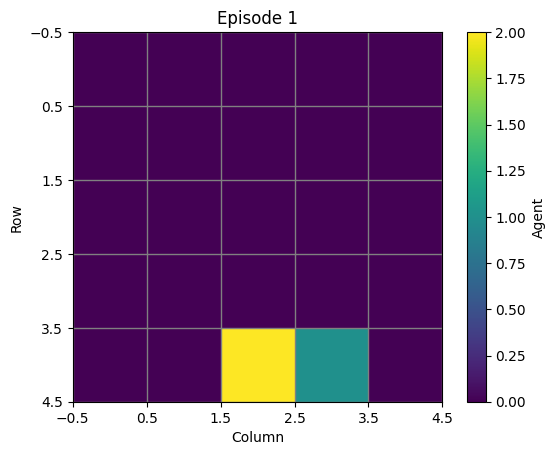

Rewards: {'agent1': 1.0, 'agent2': -1.0}
New State: [22, 17]


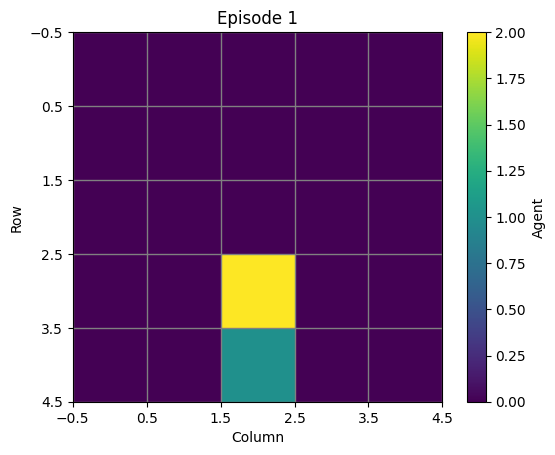

Rewards: {'agent1': -100.0, 'agent2': 100.0}
New State: [22, 17]


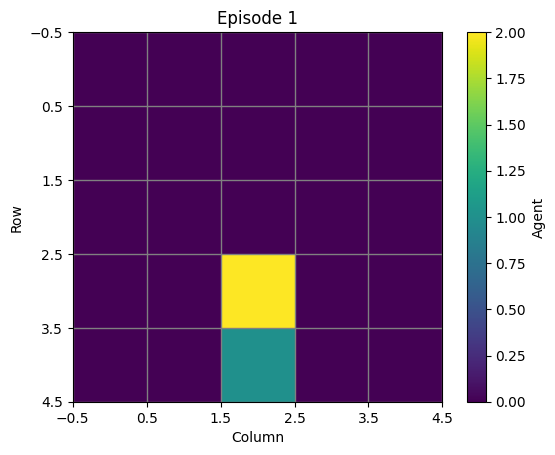

Total Reward for Episode 1: -13.5
Reward for the thief: -98.5
Reward for the policy: 85.0


In [58]:
# Initialize the environment
MA_env = MultiAgentEnvironment()
total_rewards = []

# Define the state and action space dimensions

agent_info = {"num_actions": 4, "num_states": 25, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
agent1 = QLearningAgent()
agent1.agent_init(agent_info)
agent2 = ExpectedSarsaAgent()
agent2.agent_init(agent_info)
agents = [agent1, agent2]

# Training loop
for episode in range(1):
    MA_env.env_init()
    print("Episode:", episode + 1)
    num_steps = 1
    total_reward = 0.0
    last_state = MA_env.env_start()
    last_actions = {}
    last_actions["agent1"] = agent1.agent_start(last_state[0])
    last_actions["agent2"] = agent2.agent_start(last_state[1])
    
    done = False
    while not done:
        rewards, obs, dones = MA_env.env_step(last_actions)
        total_reward += rewards["agent1"]
        total_reward += rewards["agent2"]

        print("Rewards:", rewards)
        print("New State:", obs)

        plot_grid(MA_env.agent1_pos, MA_env.agent2_pos, episode + 1)

        done = dones["__all__"]
        if done:
            agent1.agent_end(rewards["agent1"])
            agent2.agent_end(rewards["agent2"])
            break
        else:
            num_steps += 1
            last_actions = {}
            last_actions["agent1"] = agent1.agent_step(rewards["agent1"], obs[0])
            last_actions["agent2"] = agent2.agent_step(rewards["agent2"], obs[1])
    
    print("Total Reward for Episode {}: {}".format(episode + 1, total_reward))
    print("Reward for the thief: {}".format(MA_env.agent1_R))
    print("Reward for the policy: {}".format(MA_env.agent2_R))



In [66]:
def run_episode(MA_env, agent1, agent2):
    MA_env.env_init()
    total_reward = 0.0
    last_state = MA_env.env_start()
    last_actions = {}
    last_actions["agent1"] = agent1.agent_start(last_state[0])
    last_actions["agent2"] = agent2.agent_start(last_state[1])
    
    done = False
    while not done:
        rewards, obs, dones = MA_env.env_step(last_actions)
        total_reward += rewards["agent1"]
        total_reward += rewards["agent2"]

        done = dones["__all__"]
        if done:
            agent1.agent_end(rewards["agent1"])
            agent2.agent_end(rewards["agent2"])
            break
        else:
            last_actions = {}
            last_actions["agent1"] = agent1.agent_step(rewards["agent1"], obs[0])
            last_actions["agent2"] = agent2.agent_step(rewards["agent2"], obs[1])
    
    return total_reward

In [67]:
#############################################
### Experiment
#############################################

MA_env = MultiAgentEnvironment()
agent_info = {"num_actions": 4, "num_states": 25, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
agent1 = QLearningAgent()
agent1.agent_init(agent_info)
agent2 = ExpectedSarsaAgent()
agent2.agent_init(agent_info)
agents = [agent1, agent2]

num_runs = 100
num_episodes = 500

all_reward_sums = []
all_state_visits_1 = []
all_state_visits_2 = []

for run in tqdm(range(num_runs)):
    agent_info["seed"] = run
    reward_sums = []
    agent1_state_visits = np.zeros(25)
    agent2_state_visits = np.zeros(25)

    for episode in range(num_episodes):
        if episode < num_episodes - 10:
            total_reward = run_episode(MA_env, agent1, agent2)
        else:
            MA_env.env_init()
            total_reward = 0.0
            last_state = MA_env.env_start()
            last_actions = {}
            last_actions["agent1"] = agent1.agent_start(last_state[0])
            last_actions["agent2"] = agent2.agent_start(last_state[1])
            agent1_state_visits[last_state[0]] += 1
            agent2_state_visits[last_state[1]] += 1
            is_terminal = False
            while not is_terminal:
                rewards, obs, dones = MA_env.env_step(last_actions)

                agent1_state_visits[obs[0]] += 1
                agent2_state_visits[obs[1]] += 1
                total_reward += rewards["agent1"]
                total_reward += rewards["agent2"]

                done = dones["__all__"]
                if done:
                    agent1.agent_end(rewards["agent1"])
                    agent2.agent_end(rewards["agent2"])
                    break
                else:
                    last_actions = {}
                    last_actions["agent1"] = agent1.agent_step(rewards["agent1"], obs[0])
                    last_actions["agent2"] = agent2.agent_step(rewards["agent2"], obs[1])
        reward_sums.append((total_reward, MA_env.agent1_R, MA_env.agent2_R))
    
    all_reward_sums.append(reward_sums)
    all_state_visits_1.append(agent1_state_visits)
    all_state_visits_2.append(agent2_state_visits)

100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


In [71]:
len(all_reward_sums)

100

In [82]:
total_reward = []
for reward_run in all_reward_sums:
    r_epoch = []
    for reward_epoch in reward_run:
        r_epoch.append(reward_epoch[0])
    total_reward.append(r_epoch)

thief_reward = []
for reward_run in all_reward_sums:
    r_epoch = []
    for reward_epoch in reward_run:
        r_epoch.append(reward_epoch[1])
    thief_reward.append(r_epoch)

police_reward = []
for reward_run in all_reward_sums:
    r_epoch = []
    for reward_epoch in reward_run:
        r_epoch.append(reward_epoch[2])
    police_reward.append(r_epoch)

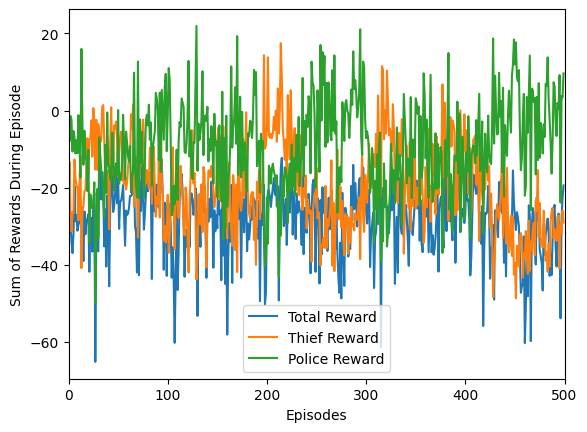

In [86]:
mean_total_reward = np.mean(total_reward, axis=0)
mean_thief_reward = np.mean(thief_reward, axis=0)
mean_police_reward = np.mean(police_reward, axis=0)

plt.plot(mean_total_reward, label='Total Reward')
plt.plot(mean_thief_reward, label='Thief Reward')
plt.plot(mean_police_reward, label='Police Reward')

plt.xlabel("Episodes")
plt.ylabel("Sum of Rewards During Episode", rotation=90)
plt.xlim(0, 500)
plt.legend()
plt.show()

In [ ]:
all_state_visits_1 = []
all_state_visits_2 = []

In [89]:
def visualize_state_visits(state_visits, title):
    grid_size = int(np.sqrt(len(state_visits)))
    state_visits_grid = np.array(state_visits).reshape((grid_size, grid_size))

    plt.imshow(state_visits_grid, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='State Visits')

    plt.title(title)
    plt.xlabel('Column')
    plt.ylabel('Row')

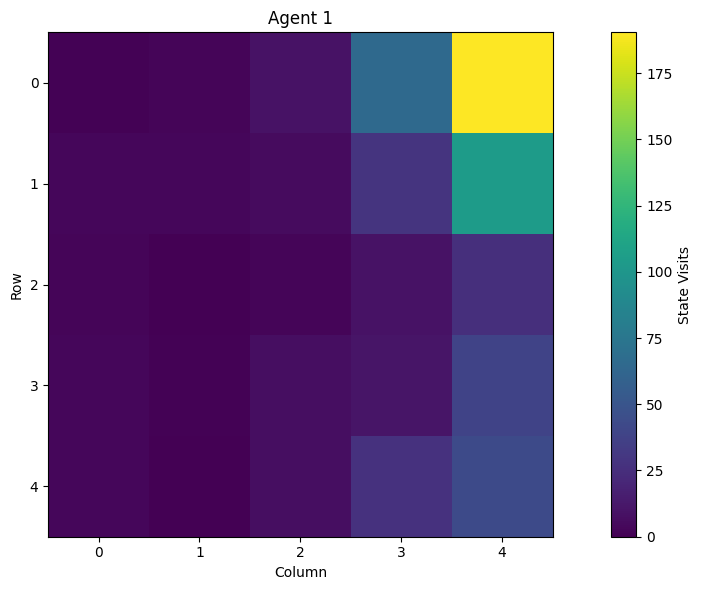

In [92]:
plt.figure(figsize=(12, 6))
average_state_visits = np.array(all_state_visits_1[-10:]).mean(axis=0)
visualize_state_visits(average_state_visits, 'Agent 1')
plt.tight_layout()
plt.show()

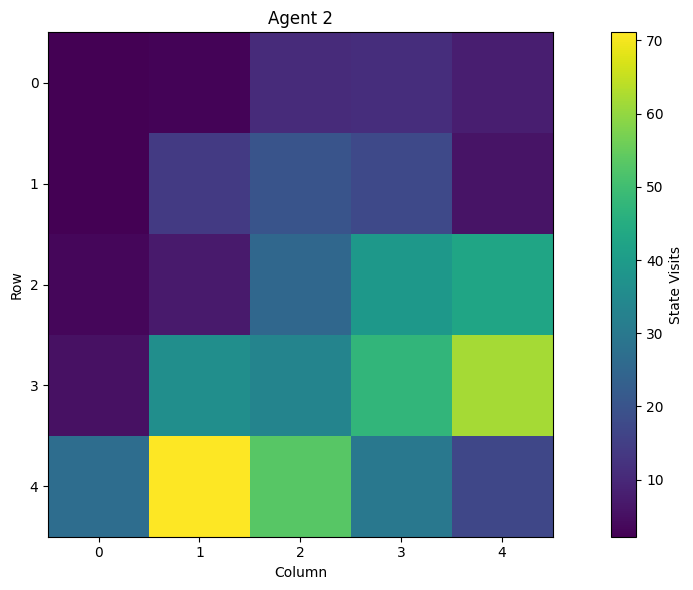

In [93]:
plt.figure(figsize=(12, 6))
average_state_visits = np.array(all_state_visits_2[-10:]).mean(axis=0)
visualize_state_visits(average_state_visits, 'Agent 2')
plt.tight_layout()
plt.show()

In [20]:
#############################################
### Evaluation
#############################################

# Initialize the environment
MA_env = MultiAgentEnvironment()
thief_win = 0
police_win = 0
thief_win_rate = []
police_win_rate = []
num_episodes = 50000

# Define the state and action space dimensions
agent_info = {"num_actions": 4, "num_states": 25, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
agent1 = QLearningAgent()
agent1.agent_init(agent_info)
agent2 = ExpectedSarsaAgent()
agent2.agent_init(agent_info)
agents = [agent1, agent2]

# Training loop
for episode in tqdm(range(num_episodes)):
    MA_env.env_init()
    last_state = MA_env.env_start()
    last_actions = {}
    last_actions["agent1"] = agent1.agent_start(last_state[0])
    last_actions["agent2"] = agent2.agent_start(last_state[1])
    
    done = False
    while not done:

        rewards, obs, dones = MA_env.env_step(last_actions)

        last_actions["agent1"] = agent1.agent_step(rewards["agent1"], obs[0])
        last_actions["agent2"] = agent2.agent_step(rewards["agent2"], obs[1])

        done = dones["__all__"]
            

    if MA_env.winner == "thief":
        thief_win += 1  
    else:
        police_win += 1
        
    thief_win_rate.append(thief_win / (episode + 1))
    police_win_rate.append(police_win / (episode + 1))

    agent1.agent_end(rewards["agent1"])
    agent2.agent_end(rewards["agent2"])

  2%|▏         | 915/50000 [00:02<01:38, 499.90it/s]

100%|██████████| 50000/50000 [01:51<00:00, 449.57it/s]


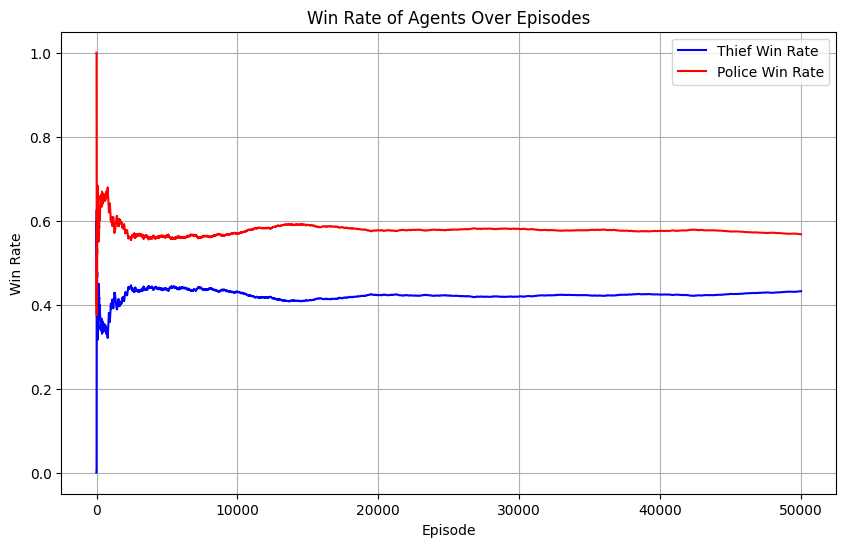

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(thief_win_rate, label='Thief Win Rate', color='blue')
plt.plot(police_win_rate, label='Police Win Rate', color='red')
plt.title('Win Rate of Agents Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Win Rate')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Initialize the environment
MA_env = MultiAgentEnvironment()
thief_win = 0
police_win = 0
thief_win_rate = []
police_win_rate = []
num_episodes = 50000

# Define the state and action space dimensions
agent_info = {"num_actions": 4, "num_states": 25, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
agent1 = QLearningAgent()
agent1.agent_init(agent_info)
agent2 = QLearningAgent()
agent2.agent_init(agent_info)
agents = [agent1, agent2]

# Training loop
for episode in tqdm(range(num_episodes)):
    MA_env.env_init()
    last_state = MA_env.env_start()
    last_actions = {}
    last_actions["agent1"] = agent1.agent_start(last_state[0])
    last_actions["agent2"] = agent2.agent_start(last_state[1])
    
    done = False
    while not done:

        rewards, obs, dones = MA_env.env_step(last_actions)

        last_actions["agent1"] = agent1.agent_step(rewards["agent1"], obs[0])
        last_actions["agent2"] = agent2.agent_step(rewards["agent2"], obs[1])

        done = dones["__all__"]
            

    if MA_env.winner == "thief":
        thief_win += 1  
    else:
        police_win += 1
        
    thief_win_rate.append(thief_win / (episode + 1))
    police_win_rate.append(police_win / (episode + 1))

    agent1.agent_end(rewards["agent1"])
    agent2.agent_end(rewards["agent2"])

100%|██████████| 50000/50000 [02:05<00:00, 398.09it/s]


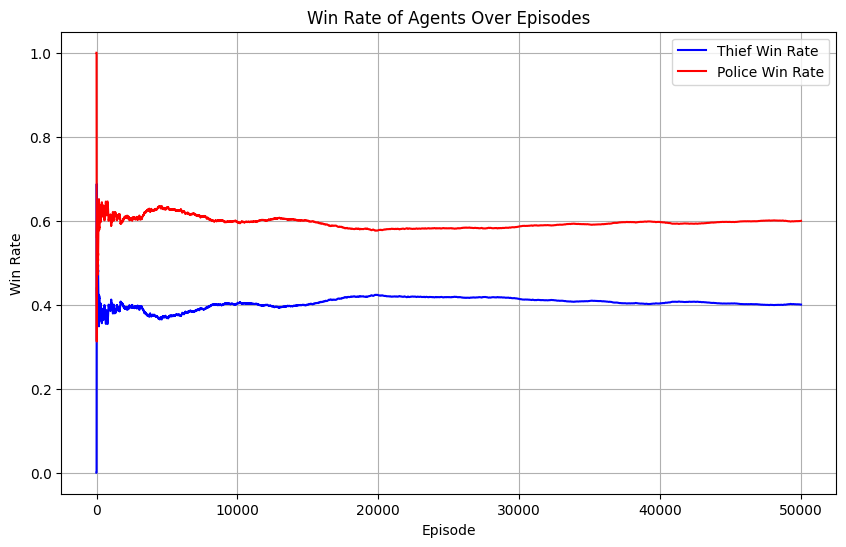

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(thief_win_rate, label='Thief Win Rate', color='blue')
plt.plot(police_win_rate, label='Police Win Rate', color='red')
plt.title('Win Rate of Agents Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Win Rate')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Initialize the environment
MA_env = MultiAgentEnvironment()
thief_win = 0
police_win = 0
thief_win_rate = []
police_win_rate = []
num_episodes = 50000

# Define the state and action space dimensions
agent_info = {"num_actions": 4, "num_states": 25, "epsilon": 0.1, "step_size": 0.1, "discount": 1.0, "seed": 0}
agent1 = ExpectedSarsaAgent()
agent1.agent_init(agent_info)
agent2 = ExpectedSarsaAgent()
agent2.agent_init(agent_info)
agents = [agent1, agent2]

# Training loop
for episode in tqdm(range(num_episodes)):
    MA_env.env_init()
    last_state = MA_env.env_start()
    last_actions = {}
    last_actions["agent1"] = agent1.agent_start(last_state[0])
    last_actions["agent2"] = agent2.agent_start(last_state[1])
    
    done = False
    while not done:

        rewards, obs, dones = MA_env.env_step(last_actions)

        last_actions["agent1"] = agent1.agent_step(rewards["agent1"], obs[0])
        last_actions["agent2"] = agent2.agent_step(rewards["agent2"], obs[1])

        done = dones["__all__"]
            

    if MA_env.winner == "thief":
        thief_win += 1  
    else:
        police_win += 1
        
    thief_win_rate.append(thief_win / (episode + 1))
    police_win_rate.append(police_win / (episode + 1))

    agent1.agent_end(rewards["agent1"])
    agent2.agent_end(rewards["agent2"])

  3%|▎         | 1573/50000 [00:02<01:19, 611.06it/s]

100%|██████████| 50000/50000 [01:20<00:00, 619.32it/s] 


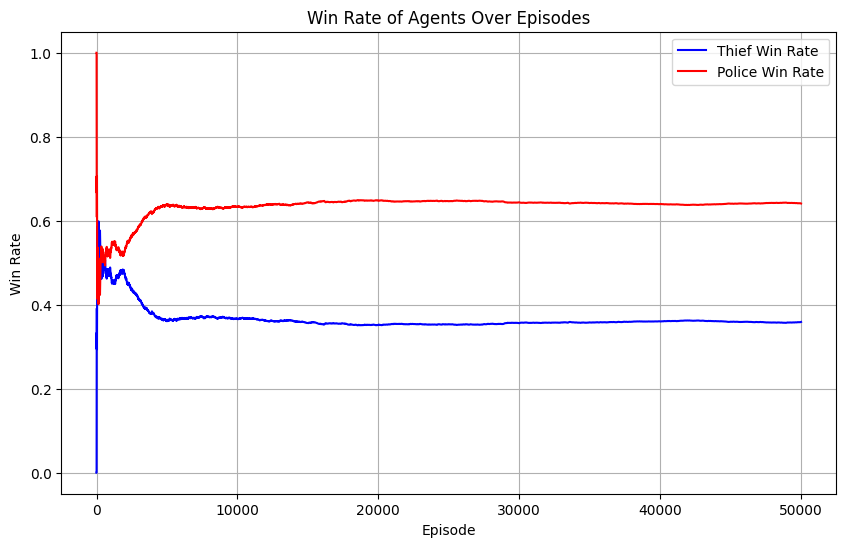

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(thief_win_rate, label='Thief Win Rate', color='blue')
plt.plot(police_win_rate, label='Police Win Rate', color='red')
plt.title('Win Rate of Agents Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Win Rate')
plt.legend()
plt.grid(True)
plt.show()